# Introduction
This notebook analyzes cleaned data in order to understand the relationship between temperature and kelp growth in the Salish Sea

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Import Data

In [2]:
path = "https://raw.githubusercontent.com/sgolden3/Data-5100-Kelp/refs/heads/main/Data/cleaned_data/"

df = pd.read_csv("https://raw.githubusercontent.com/sgolden3/Data-5100-Kelp/refs/heads/main/Data/cleaned_data/AllBeds_Clean.csv")

## Make one consolidated temperature column

### Define temp columns

### Temperature function

In [3]:
def fill_temperature(df):
    """
    Fills a new temperature column 'Temp_Final' using the following logic:

    1. If Temp exists → use Temp
    2. Else:
        a. If both Ave Temp Shore Edge and Ave Temp Water Edge exist:
              (Ave Temp Shore Edge + Ave Temp Water Edge) / 2
        b. Else:
              ((Temp1 Shore Edge + Temp2 Shore Edge)/2  +
               (Temp1 Water Edge + Temp2 Water Edge)/2) / 2
    """

    df["Temp_Final"] = np.where(
        ~df["Temp"].isna(),                      # Case 1: Temp exists
        df["Temp"],                              # → use Temp

        np.where(
            (~df["Ave Temp Shore Edge"].isna()) &
            (~df["Ave Temp Water Edge"].isna()), # Case 2a: both average temps exist
            (df["Ave Temp Shore Edge"] + df["Ave Temp Water Edge"]) / 2,

            # Case 2b: fallback using Temp1/Temp2 averages
            (
                ((df["Temp1 Shore Edge"] + df["Temp2 Shore Edge"]) / 2) +
                ((df["Temp1 Water Edge"] + df["Temp2 Water Edge"]) / 2)
            ) / 2
        )
    )

    return df

In [4]:
temp_cols = ["Temp1 Shore Edge","Temp2 Shore Edge","Temp1 Water Edge","Temp2 Water Edge"]
df[temp_cols] = df[temp_cols].apply(pd.to_numeric, errors="coerce")
df = fill_temperature(df)

In [5]:
temp_cols_all = [
    'Temp', 'Temp1 Shore Edge', 'Temp1 Water Edge',
    'Temp2 Shore Edge', 'Temp2 Water Edge',
    'Ave Temp Shore Edge', 'Ave Temp Water Edge']

all_nan_rows = df[df[temp_cols_all].isnull().all(axis=1)]
all_nan_rows.shape

(28, 16)

### Find Historical Temps

### Restrict to only NWSC 1 columns

Create a Pct Change columns

In [6]:
# 1. Select Max Extent only
df_max = (df[df["NWSC Max Ext"] == 1]
.sort_values(["Site Code", "Survey Year", "Acres"],
       ascending=[True, True, False])
.drop_duplicates(subset=["Site Code", "Survey Year"], keep="first")
.copy()
)

df_max["PctAcreChange"] = (
df_max.groupby("Site Code")["Acres"]
.pct_change()
* 100
)


### Make a function to find hisotrical temperatures

In [7]:
# Convert 'Survey Date' to datetime for DateOffset operations
df_max['Survey Date'] = pd.to_datetime(df_max['Survey Date'])

In [8]:
def get_historical_temperatures(row, df_search):
    """
    Finds historical temperatures for the same site code, month, and day in previous years.

    Args:
        row (pd.Series): A row from the DataFrame (df_max) containing 'Survey Date' and 'Site Code'.
        df_search (pd.DataFrame): The DataFrame to search for historical temperatures (e.g., df_max itself).

    Returns:
        tuple: (temp_one_year_prior, temp_two_years_prior, temp_three_years_prior, temp_four_years_prior)
               or (pd.NA, pd.NA, pd.NA, pd.NA) if not found.
    """
    current_date = row['Survey Date']
    current_site_code = row['Site Code']

    if pd.isna(current_date):
        return pd.NA, pd.NA, pd.NA, pd.NA

    # Helper to get temperature for a specific date, returning NaN if not found
    def get_temp_for_date_and_site(target_date, site_code_to_match, df_filtered_for_temp):
        # Filter for the exact site code, year, month
        match = df_filtered_for_temp[
            (df_filtered_for_temp['Site Code'] == site_code_to_match) &
            (df_filtered_for_temp['Survey Date'].dt.year == target_date.year)
        ]
        if not match.empty:
            # We are looking for the 'Temp_Final' column which was created earlier
            return match['Temp_Final'].iloc[0]
        return pd.NA

    # Calculate target dates for prior years
    one_year_ago = current_date - pd.DateOffset(years=1)
    two_years_ago = current_date - pd.DateOffset(years=2)
    three_years_ago = current_date - pd.DateOffset(years=3)
    four_years_ago = current_date - pd.DateOffset(years=4)

    temp_one_year_prior = get_temp_for_date_and_site(one_year_ago, current_site_code, df_search)
    temp_two_years_prior = get_temp_for_date_and_site(two_years_ago, current_site_code, df_search)
    temp_three_years_prior = get_temp_for_date_and_site(three_years_ago, current_site_code, df_search)
    temp_four_years_prior = get_temp_for_date_and_site(four_years_ago, current_site_code, df_search)

    return temp_one_year_prior, temp_two_years_prior, temp_three_years_prior, temp_four_years_prior

# Apply the function to df_max
df_max[[
    "Temp_t_minus1", "Temp_t_minus2",
    "Temp_t_minus3", "Temp_t_minus4"
]] = df_max.apply(lambda row: get_historical_temperatures(row, df_max), axis=1, result_type='expand')

print("Function 'get_historical_temperatures' modified and applied successfully.")

Function 'get_historical_temperatures' modified and applied successfully.


In [9]:
df_max.rename(columns={'Temp_Final': 'Temp_t'}, inplace=True)

## Impute missing data

In [17]:
 #2.1 Temp Imputation
temp_cols = ["Temp_t", "Temp_t_minus1", "Temp_t_minus2",
              "Temp_t_minus3", "Temp_t_minus4"]

monthly_avgs = (
    df_max.groupby(["Site Code", "Survey Month"])["Temp_t"]
          .mean()
          .rename("MonthlyTempMean")
)

df_max = df_max.merge(monthly_avgs, on=["Site Code", "Survey Month"], how="left")

for col in temp_cols:
    df_max[col] = df_max[col].fillna(df_max["MonthlyTempMean"])

/tmp/ipython-input-4116937996.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_max[col] = df_max[col].fillna(df_max["MonthlyTempMean"])


In [18]:
df_max

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
0,Aiston Preserve,AISP,2018-07-31,31.0,1.0,7.0,2018.0,0.117903,16.0,NaN,...,NaN,NaN,NaN,16.000,NaN,15.415,15.415,15.415,15.415,15.4150
1,Aiston Preserve,AISP,2019-08-01,1.0,1.0,8.0,2019.0,0.167167,16.0,NaN,...,NaN,NaN,NaN,16.000,41.783878,16.000,16.000,16.000,16.000,16.0000
2,Aiston Preserve,AISP,2020-07-20,20.0,1.0,7.0,2020.0,0.327542,NaN,15.00,...,15.00,15.30,15.00,15.150,95.936898,16.000,16.000,15.415,15.415,15.4150
3,Aiston Preserve,AISP,2021-07-27,27.0,1.0,7.0,2021.0,0.207529,NaN,14.44,...,14.44,14.44,14.44,14.440,-36.640490,15.150,16.000,16.000,15.415,15.4150
4,Aiston Preserve,AISP,2022-07-31,31.0,1.0,7.0,2022.0,0.296172,NaN,20.00,...,20.00,20.00,20.00,20.000,42.713633,14.440,15.150,16.000,16.000,15.4150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Shannon Point West,SHPT-W,2020-09-18,18.0,1.0,9.0,2020.0,7.790410,NaN,11.30,...,NaN,11.30,11.50,11.400,76.472068,14.000,16.000,12.000,12.649,12.6490
133,Shannon Point West,SHPT-W,2021-09-19,19.0,1.0,9.0,2021.0,4.860296,NaN,11.11,...,10.56,11.11,10.28,10.695,-37.611814,11.400,14.000,16.000,12.000,12.6490
134,Shannon Point West,SHPT-W,2022-08-12,12.0,1.0,8.0,2022.0,3.267264,NaN,12.78,...,NaN,12.78,11.11,11.945,-32.776441,10.695,11.400,14.000,16.000,12.0725
135,Shannon Point West,SHPT-W,2023-09-01,1.0,1.0,9.0,2023.0,4.720687,NaN,13.30,...,13.30,12.90,13.40,13.150,44.484413,11.945,10.695,11.400,14.000,12.6490


## Make a function to find correlations for all of the beds

In [24]:
def corr_max(df):
  # 3. Predictor list
  predictor_variables = ["Temp_t",
      "Temp_t_minus1", "Temp_t_minus2",
    "Temp_t_minus3", "Temp_t_minus4"
  ]

  # 4. Numerical predictors
  numerical_predictors = (
      df[predictor_variables]
      .select_dtypes(include="number")
      .columns
      .to_list()
  )

  # 5. Correlation matrix with Acres appended
  corr_matrix = df[numerical_predictors + ["Acres", "PctAcreChange"]].corr()

  # Subset of columns to show
  selected_cols = [
      "Site Code", "Survey Day", "Survey Month", "Survey Year",
      "Acres", "Temp_t", "Temp_t_minus1", "Temp_t_minus2",
    "Temp_t_minus3", "Temp_t_minus4", "PctAcreChange"
  ]

  df_selected = df[selected_cols]

  # 6. Heatmap
  sns.heatmap(
      corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
  )
  plt.tick_params(labelsize=12)
  plt.title("Max Extent vs Temp Correlation Matrix", fontsize=14)
  plt.show()

  df_selected
  return df_selected

In [25]:
df_max['Site Code'].unique()

array(['AISP', 'BZPT', 'BZPT-S', 'CHPT', 'CLLB', 'COFF', 'EBL', 'FWB',
       'FWBO', 'HAT-S', 'HOYP', 'LMMI-SW', 'LWLP', 'NB-E', 'POLN', 'POSS',
       'SHPT-E', 'SHPT-W'], dtype=object)

## Correlation Matrices

### All beds

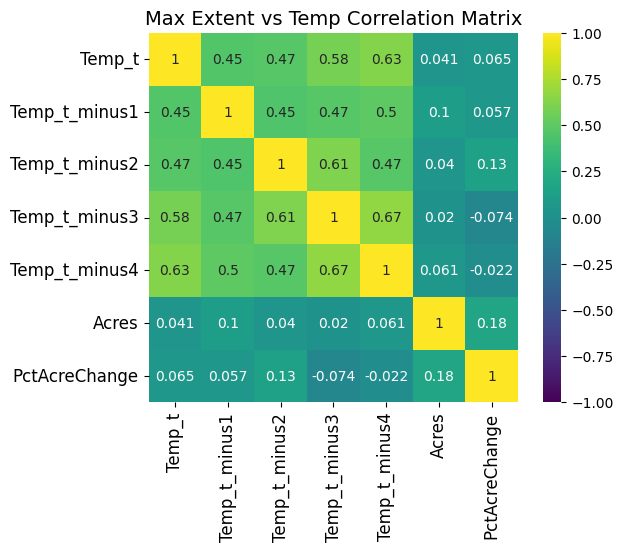

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
0,AISP,31.0,7.0,2018.0,0.117903,16.000,15.415,15.415,15.415,15.415,NaN
1,AISP,1.0,8.0,2019.0,0.167167,16.000,16.000,16.000,16.000,16.000,41.783878
2,AISP,20.0,7.0,2020.0,0.327542,15.150,16.000,16.000,15.415,15.415,95.936898
3,AISP,27.0,7.0,2021.0,0.207529,14.440,15.150,16.000,16.000,15.415,-36.640490
4,AISP,31.0,7.0,2022.0,0.296172,20.000,14.440,15.150,16.000,16.000,42.713633
...,...,...,...,...,...,...,...,...,...,...,...
132,SHPT-W,18.0,9.0,2020.0,7.790410,11.400,14.000,16.000,12.000,12.649,76.472068
133,SHPT-W,19.0,9.0,2021.0,4.860296,10.695,11.400,14.000,16.000,12.000,-37.611814
134,SHPT-W,12.0,8.0,2022.0,3.267264,11.945,10.695,11.400,14.000,16.000,-32.776441
135,SHPT-W,1.0,9.0,2023.0,4.720687,13.150,11.945,10.695,11.400,14.000,44.484413


In [28]:
corr_max(df_max)

### Ebey

In [26]:
ebey = df_max[df_max['Site Code']== 'EBL']
ebey

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
39,Ebey's Landing,EBL,2015-08-15,15.0,1.0,8.0,2015.0,18.354044,13.0,NaN,...,NaN,NaN,NaN,13.00,NaN,12.18125,12.18125,12.18125,12.18125,12.18125
40,Ebey's Landing,EBL,2016-07-22,22.0,1.0,7.0,2016.0,20.396699,12.0,NaN,...,NaN,NaN,NaN,12.00,11.129181,13.00000,12.00000,12.00000,12.00000,12.00000
41,Ebey's Landing,EBL,2017-09-16,16.0,1.0,9.0,2017.0,21.534815,11.0,NaN,...,NaN,NaN,NaN,11.00,5.579906,12.00000,13.00000,11.00000,11.00000,11.00000
42,Ebey's Landing,EBL,2018-08-07,7.0,1.0,8.0,2018.0,21.293413,12.0,NaN,...,NaN,NaN,NaN,12.00,-1.120989,11.00000,12.00000,13.00000,12.18125,12.18125
43,Ebey's Landing,EBL,2019-08-13,13.0,1.0,8.0,2019.0,41.131154,13.0,NaN,...,12.7,NaN,NaN,13.00,93.163749,12.00000,11.00000,12.00000,13.00000,12.18125
44,Ebey's Landing,EBL,2020-08-30,30.0,1.0,8.0,2020.0,41.614620,NaN,11.9,...,NaN,11.90,12.00,11.95,1.175426,13.00000,12.00000,11.00000,12.00000,12.18125
45,Ebey's Landing,EBL,2021-08-11,11.0,1.0,8.0,2021.0,37.681341,NaN,12.0,...,NaN,12.00,12.00,12.00,-9.451676,11.95000,13.00000,12.00000,11.00000,12.18125
46,Ebey's Landing,EBL,2022-08-23,23.0,1.0,8.0,2022.0,38.629817,NaN,11.9,...,12.2,12.05,12.25,12.15,2.517096,12.00000,11.95000,13.00000,12.00000,12.18125
47,Ebey's Landing,EBL,2023-08-14,14.0,1.0,8.0,2023.0,31.122627,NaN,11.8,...,12.2,11.80,12.20,12.00,-19.433665,12.15000,12.00000,11.95000,13.00000,12.18125
48,Ebey's Landing,EBL,2024-08-20,20.0,1.0,8.0,2024.0,33.207906,NaN,11.0,...,11.4,11.40,11.30,11.35,6.700200,12.00000,12.15000,12.00000,11.95000,12.18125


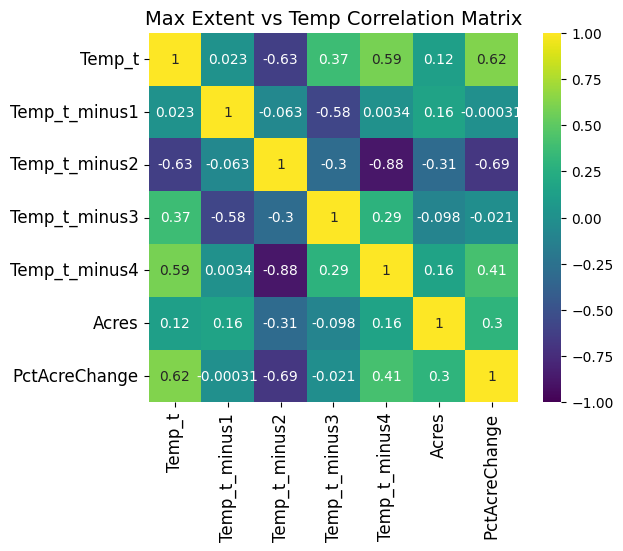

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
39,EBL,15.0,8.0,2015.0,18.354044,13.00,12.18125,12.18125,12.18125,12.18125,NaN
40,EBL,22.0,7.0,2016.0,20.396699,12.00,13.00000,12.00000,12.00000,12.00000,11.129181
41,EBL,16.0,9.0,2017.0,21.534815,11.00,12.00000,13.00000,11.00000,11.00000,5.579906
42,EBL,7.0,8.0,2018.0,21.293413,12.00,11.00000,12.00000,13.00000,12.18125,-1.120989
43,EBL,13.0,8.0,2019.0,41.131154,13.00,12.00000,11.00000,12.00000,13.00000,93.163749
44,EBL,30.0,8.0,2020.0,41.614620,11.95,13.00000,12.00000,11.00000,12.00000,1.175426
45,EBL,11.0,8.0,2021.0,37.681341,12.00,11.95000,13.00000,12.00000,11.00000,-9.451676
46,EBL,23.0,8.0,2022.0,38.629817,12.15,12.00000,11.95000,13.00000,12.00000,2.517096
47,EBL,14.0,8.0,2023.0,31.122627,12.00,12.15000,12.00000,11.95000,13.00000,-19.433665
48,EBL,20.0,8.0,2024.0,33.207906,11.35,12.00000,12.15000,12.00000,11.95000,6.700200


In [27]:
corr_max(ebey)

Possession Point - Ahrial

Polnell (mostly August) - Ahrial

North Beach - Ahrial

In [29]:
df_max['Site Code'].unique()

array(['AISP', 'BZPT', 'BZPT-S', 'CHPT', 'CLLB', 'COFF', 'EBL', 'FWB',
       'FWBO', 'HAT-S', 'HOYP', 'LMMI-SW', 'LWLP', 'NB-E', 'POLN', 'POSS',
       'SHPT-E', 'SHPT-W'], dtype=object)

### Possession Point

In [33]:
poss = df_max[df_max['Site Code']== 'POSS']
poss

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
113,Possession Point,POSS,2017-08-24,24.0,1.0,8.0,2017.0,21.484920,13.0,NaN,...,NaN,NaN,NaN,13.000,NaN,15.382143,15.382143,15.382143,15.382143,15.382143
114,Possession Point,POSS,2018-08-14,14.0,1.0,8.0,2018.0,38.002331,16.0,NaN,...,NaN,NaN,NaN,16.000,76.879088,13.000000,15.382143,15.382143,15.382143,15.382143
115,Possession Point,POSS,2019-08-16,16.0,1.0,8.0,2019.0,60.670912,15.0,NaN,...,NaN,NaN,NaN,15.000,59.650501,16.000000,13.000000,15.382143,15.382143,15.382143
116,Possession Point,POSS,2020-08-31,31.0,1.0,8.0,2020.0,51.085699,NaN,15.0,...,NaN,15.00,14.50,14.750,-15.798696,15.000000,16.000000,13.000000,15.382143,15.382143
117,Possession Point,POSS,2021-08-11,11.0,1.0,8.0,2021.0,65.733887,NaN,16.0,...,18.0,16.00,17.50,16.750,28.673755,14.750000,15.000000,16.000000,13.000000,15.382143
118,Possession Point,POSS,2022-09-10,10.0,1.0,9.0,2022.0,88.630361,NaN,14.5,...,14.5,14.25,14.25,14.250,34.832071,16.750000,14.750000,15.000000,16.000000,14.250000
119,Possession Point,POSS,2023-08-14,14.0,1.0,8.0,2023.0,85.887200,NaN,16.8,...,18.6,17.00,17.60,17.300,-3.095059,14.250000,16.750000,14.750000,15.000000,15.382143
120,Possession Point,POSS,2024-08-16,16.0,1.0,8.0,2024.0,75.564707,NaN,14.8,...,14.8,15.05,14.70,14.875,-12.018662,17.300000,14.250000,16.750000,14.750000,15.382143


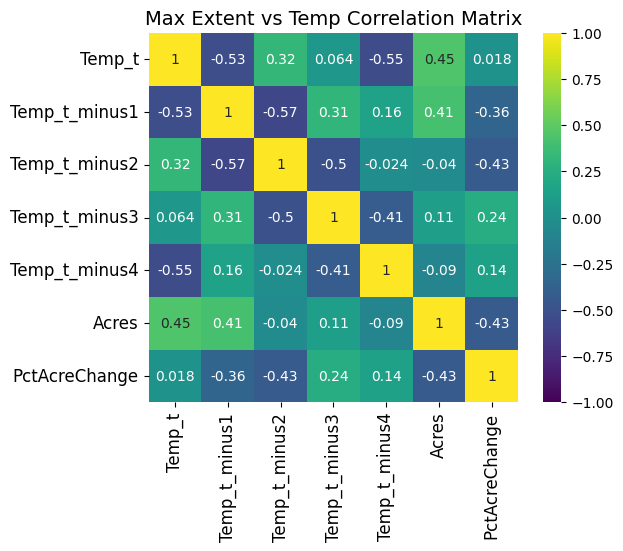

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
113,POSS,24.0,8.0,2017.0,21.484920,13.000,15.382143,15.382143,15.382143,15.382143,NaN
114,POSS,14.0,8.0,2018.0,38.002331,16.000,13.000000,15.382143,15.382143,15.382143,76.879088
115,POSS,16.0,8.0,2019.0,60.670912,15.000,16.000000,13.000000,15.382143,15.382143,59.650501
116,POSS,31.0,8.0,2020.0,51.085699,14.750,15.000000,16.000000,13.000000,15.382143,-15.798696
117,POSS,11.0,8.0,2021.0,65.733887,16.750,14.750000,15.000000,16.000000,13.000000,28.673755
118,POSS,10.0,9.0,2022.0,88.630361,14.250,16.750000,14.750000,15.000000,16.000000,34.832071
119,POSS,14.0,8.0,2023.0,85.887200,17.300,14.250000,16.750000,14.750000,15.000000,-3.095059
120,POSS,16.0,8.0,2024.0,75.564707,14.875,17.300000,14.250000,16.750000,14.750000,-12.018662


In [34]:
corr_max(poss)

### Polnell

In [37]:
polnell = df_max[df_max['Site Code']== 'POLN']
polnell

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
104,Polnell Point,POLN,2016-08-30,30.0,1.0,8.0,2016.0,36.728040,17.0,NaN,...,NaN,NaN,NaN,17.000,NaN,14.795,14.795,14.795,14.795,14.795
105,Polnell Point,POLN,2017-09-18,18.0,1.0,9.0,2017.0,27.432119,NaN,NaN,...,NaN,NaN,NaN,13.700,-25.310147,17.000,13.700,13.700,13.700,13.700
106,Polnell Point,POLN,2018-09-10,10.0,1.0,9.0,2018.0,75.709687,13.0,NaN,...,NaN,NaN,NaN,13.000,175.989204,13.700,17.000,13.700,13.700,13.700
107,Polnell Point,POLN,2019-09-26,26.0,1.0,9.0,2019.0,47.312350,15.0,NaN,...,NaN,NaN,NaN,15.000,-37.508195,13.000,13.700,17.000,13.700,13.700
108,Polnell Point,POLN,2020-08-31,31.0,1.0,8.0,2020.0,41.303716,NaN,13.9,...,NaN,13.90,13.2,13.550,-12.699927,15.000,13.000,14.795,17.000,14.795
109,Polnell Point,POLN,2021-08-24,24.0,1.0,8.0,2021.0,36.426616,NaN,13.6,...,13.9,13.60,13.8,13.700,-11.807897,13.550,15.000,13.000,14.795,14.795
110,Polnell Point,POLN,2022-09-11,11.0,1.0,9.0,2022.0,17.561865,NaN,13.2,...,12.9,13.20,13.0,13.100,-51.788371,13.700,13.550,15.000,13.000,13.700
111,Polnell Point,POLN,2023-08-15,15.0,1.0,8.0,2023.0,38.712918,NaN,14.9,...,14.8,15.50,15.4,15.450,120.437399,13.100,13.700,13.550,15.000,14.795
112,Polnell Point,POLN,2024-08-21,21.0,1.0,8.0,2024.0,35.730997,NaN,14.5,...,14.1,14.15,14.4,14.275,-7.702650,15.450,13.100,13.700,13.550,14.795


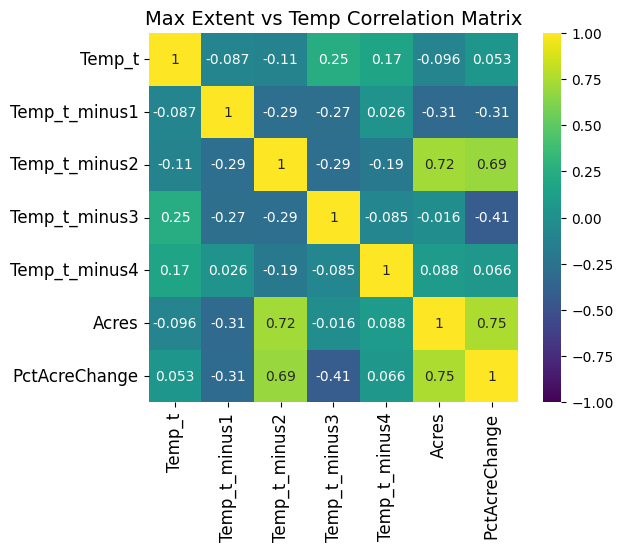

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
104,POLN,30.0,8.0,2016.0,36.728040,17.000,14.795,14.795,14.795,14.795,NaN
105,POLN,18.0,9.0,2017.0,27.432119,13.700,17.000,13.700,13.700,13.700,-25.310147
106,POLN,10.0,9.0,2018.0,75.709687,13.000,13.700,17.000,13.700,13.700,175.989204
107,POLN,26.0,9.0,2019.0,47.312350,15.000,13.000,13.700,17.000,13.700,-37.508195
108,POLN,31.0,8.0,2020.0,41.303716,13.550,15.000,13.000,14.795,17.000,-12.699927
109,POLN,24.0,8.0,2021.0,36.426616,13.700,13.550,15.000,13.000,14.795,-11.807897
110,POLN,11.0,9.0,2022.0,17.561865,13.100,13.700,13.550,15.000,13.000,-51.788371
111,POLN,15.0,8.0,2023.0,38.712918,15.450,13.100,13.700,13.550,15.000,120.437399
112,POLN,21.0,8.0,2024.0,35.730997,14.275,15.450,13.100,13.700,13.550,-7.702650


In [38]:
corr_max(polnell)

### North Beach

In [39]:
nobo = df_max[df_max['Site Code']== 'NB-E']
nobo

,Bed Name,Site Code,Survey Date,Survey Day,NWSC Max Ext,Survey Month,Survey Year,Acres,Temp,Temp1 Shore Edge,...,Temp2 Water Edge,Ave Temp Shore Edge,Ave Temp Water Edge,Temp_t,PctAcreChange,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,MonthlyTempMean
95,North Beach East,NB-E,2016-09-22,22.0,1.0,9.0,2016.0,22.091116,13.0,NaN,...,NaN,NaN,NaN,13.0000,NaN,13.0000,13.0000,13.0000,13.0000,13.0000
96,North Beach East,NB-E,2017-07-22,22.0,1.0,7.0,2017.0,18.515317,11.0,NaN,...,NaN,NaN,NaN,11.0000,-16.186594,13.0000,11.0000,11.0000,11.0000,11.0000
97,North Beach East,NB-E,2018-08-25,25.0,1.0,8.0,2018.0,9.329159,NaN,NaN,...,NaN,NaN,NaN,12.2125,-49.613831,11.0000,13.0000,12.2125,12.2125,12.2125
98,North Beach East,NB-E,2019-09-02,2.0,1.0,9.0,2019.0,11.850943,13.0,NaN,...,NaN,NaN,NaN,13.0000,27.031207,13.0000,11.0000,13.0000,13.0000,13.0000
99,North Beach East,NB-E,2020-08-26,26.0,1.0,8.0,2020.0,14.853054,NaN,14.0,...,NaN,14.00,14.00,14.0000,25.332255,13.0000,12.2125,11.0000,13.0000,12.2125
100,North Beach East,NB-E,2021-08-20,20.0,1.0,8.0,2021.0,25.579078,NaN,12.1,...,NaN,12.10,NaN,12.2125,72.214270,14.0000,13.0000,12.2125,11.0000,12.2125
101,North Beach East,NB-E,2022-08-27,27.0,1.0,8.0,2022.0,19.145410,NaN,11.8,...,11.6,11.65,11.55,11.6000,-25.152071,12.2125,14.0000,13.0000,12.2125,12.2125
102,North Beach East,NB-E,2023-08-12,12.0,1.0,8.0,2023.0,18.188146,NaN,11.8,...,11.8,12.00,11.80,11.9000,-4.999968,11.6000,12.2125,14.0000,13.0000,12.2125
103,North Beach East,NB-E,2024-08-17,17.0,1.0,8.0,2024.0,19.296391,NaN,NaN,...,10.9,11.80,10.90,11.3500,6.093229,11.9000,11.6000,12.2125,14.0000,12.2125


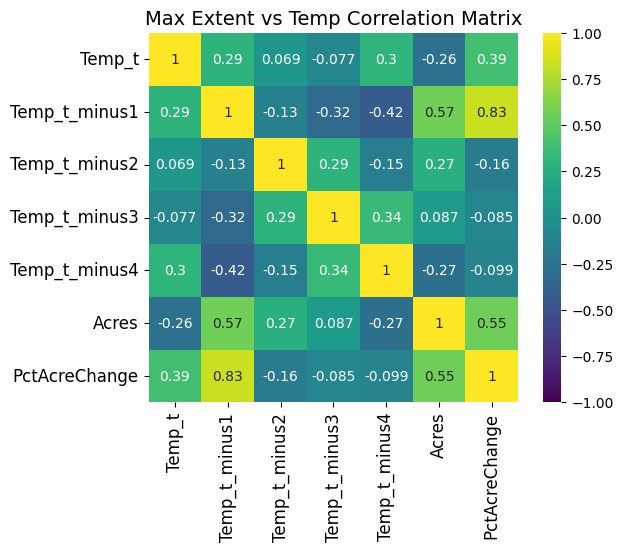

,Site Code,Survey Day,Survey Month,Survey Year,Acres,Temp_t,Temp_t_minus1,Temp_t_minus2,Temp_t_minus3,Temp_t_minus4,PctAcreChange
95,NB-E,22.0,9.0,2016.0,22.091116,13.0000,13.0000,13.0000,13.0000,13.0000,NaN
96,NB-E,22.0,7.0,2017.0,18.515317,11.0000,13.0000,11.0000,11.0000,11.0000,-16.186594
97,NB-E,25.0,8.0,2018.0,9.329159,12.2125,11.0000,13.0000,12.2125,12.2125,-49.613831
98,NB-E,2.0,9.0,2019.0,11.850943,13.0000,13.0000,11.0000,13.0000,13.0000,27.031207
99,NB-E,26.0,8.0,2020.0,14.853054,14.0000,13.0000,12.2125,11.0000,13.0000,25.332255
100,NB-E,20.0,8.0,2021.0,25.579078,12.2125,14.0000,13.0000,12.2125,11.0000,72.214270
101,NB-E,27.0,8.0,2022.0,19.145410,11.6000,12.2125,14.0000,13.0000,12.2125,-25.152071
102,NB-E,12.0,8.0,2023.0,18.188146,11.9000,11.6000,12.2125,14.0000,13.0000,-4.999968
103,NB-E,17.0,8.0,2024.0,19.296391,11.3500,11.9000,11.6000,12.2125,14.0000,6.093229


In [40]:
corr_max(nobo)